# Comparing models: Burrito Dataset

In [21]:
# imports!
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

## Task 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- Do train/validate/test split. 
- Begin with baselines for classification.
- Use scikit-learn for various models.
- Get each model's metrics (accuracy, precision, recall, etc.)
- Compare models

In [2]:
# Create your data path
from pathlib import Path
import os
DATA_PATH = Path.cwd().parent.parent.joinpath('data')
print(DATA_PATH)
print(os.listdir(DATA_PATH))

/home/studio-lab-user/intuit-ga-dat17/lectures/12-random-forest/data
['apartments', 'banknote.csv', 'beer.txt', 'burritos_cleaned.csv', 'counties.csv', 'default_features_1059_tracks.txt', 'faithful.csv', 'hitters.csv', 'nutrients.txt', 'salaries_census.csv', 'stumble-upon.tsv', 'stumbleupon-data.md', 'titanic.csv', 'vehicles_test.csv', 'vehicles_train.csv', 'walk.csv', 'waterpumps']


In [3]:
# specify the burritos.csv file
filename = Path.joinpath(DATA_PATH, 'burritos_cleaned.csv')

In [4]:
# read in the dataframe
df = pd.read_csv(filename)
df.shape

(421, 56)

In [7]:
# take a look
df.sample(5)

,Burrito,Date,Chips,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,...,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
196,Surf & Turf,8/30/2016,0,8.25,3.5,20.0,22.0,0.77,3.6,3.2,...,0,0,0,0,0,0,1,0,0,False
212,California,8/30/2016,0,7.50,2.0,19.0,25.0,0.94,4.0,5.0,...,0,0,0,0,0,0,0,0,0,True
208,California,8/30/2016,0,7.50,2.5,19.0,23.5,0.83,3.0,3.0,...,0,0,0,0,0,0,0,0,0,False
16,Surf & Turf,2/12/2016,0,8.49,2.5,NaN,NaN,NaN,4.0,4.0,...,0,0,0,0,0,0,0,0,0,True
396,Carnitas,4/20/2018,0,5.99,3.0,20.0,20.5,0.67,2.0,5.0,...,0,0,0,0,0,0,0,0,0,True


## Data Preparation

In [8]:
# what are the columns?
df.columns

Index(['Burrito', 'Date', 'Chips', 'Cost', 'Hunger', 'Length', 'Circum',
       'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling',
       'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'overall', 'Rec',
       'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac', 'Cheese', 'Fries',
       'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice', 'Beans',
       'Lettuce', 'Tomato', 'Bell peper', 'Carrots', 'Cabbage', 'Sauce',
       'Salsa.1', 'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham',
       'Chile relleno', 'Nopales', 'Lobster', 'Egg', 'Mushroom', 'Bacon',
       'Sushi', 'Avocado', 'Corn', 'Zucchini', 'Great'],
      dtype='object')

In [9]:
# Check for missing data
df.isnull().sum().sort_values(ascending=False).head()

Volume       144
Circum       140
Length       138
Burrito        0
Pineapple      0
dtype: int64

In [10]:
# impute the missing data using the average of the column
for col in ['Volume', 'Circum', 'Length' ]:
    df[col]=df[col].fillna(round(df[col].mean(), 2))

In [11]:
# Confirm that fixed the problem
df.isnull().sum().sort_values(ascending=False).head()

Burrito    0
Date       0
Fish       0
Rice       0
Beans      0
dtype: int64

In [12]:
# check out the categorical variable
df['Burrito'].value_counts()

California     169
Other          156
Asada           43
Surf & Turf     28
Carnitas        25
Name: Burrito, dtype: int64

In [13]:
# convert the categorical variable to dummies via one-hot encoding
onehot = pd.get_dummies(df['Burrito'])
onehot.head()

,Asada,California,Carnitas,Other,Surf & Turf
0,0,1,0,0,0
1,0,1,0,0,0
2,0,0,1,0,0
3,1,0,0,0,0
4,0,1,0,0,0


In [14]:
# use pd.concat to join the new columns with your original dataframe
df = pd.concat([df,onehot],axis=1)
df[['Burrito', 'Asada','California','Carnitas','Other','Surf & Turf']].head()

,Burrito,Asada,California,Carnitas,Other,Surf & Turf
0,California,0,1,0,0,0
1,California,0,1,0,0,0
2,Carnitas,0,0,1,0,0
3,Asada,1,0,0,0,0
4,California,0,1,0,0,0


In [15]:
# now drop the original column (you don't need it anymore)
df=df.drop(['Burrito'],axis=1)
df.shape

(421, 60)

In [16]:
# Drop some columns -- these are related to our target var - to prevent "leakage"
# we also drop the date column because it's not immediately useable
df = df.drop(columns=['Rec', 'overall', 'Date'], axis=1)
df.head()

,Chips,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,...,Sushi,Avocado,Corn,Zucchini,Great,Asada,California,Carnitas,Other,Surf & Turf
0,0,6.49,3.0,20.04,22.14,0.79,3.0,5.0,3.0,3.5,...,0,0,0,0,False,0,1,0,0,0
1,0,5.45,3.5,20.04,22.14,0.79,2.0,3.5,2.5,2.5,...,0,0,0,0,False,0,1,0,0,0
2,0,4.85,1.5,20.04,22.14,0.79,3.0,2.0,2.5,3.0,...,0,0,0,0,False,0,0,1,0,0
3,0,5.25,2.0,20.04,22.14,0.79,3.0,2.0,3.5,3.0,...,0,0,0,0,False,1,0,0,0,0
4,1,6.59,4.0,20.04,22.14,0.79,4.0,5.0,4.0,3.5,...,0,0,0,0,True,0,1,0,0,0


In [17]:
# check out the target. convert it to an integer (unnecessary but makes it a little easier to read)
df['Great']=df['Great'].astype(int)
df['Great'].value_counts()

0    239
1    182
Name: Great, dtype: int64

## Prepare for Modeling

In [18]:
# Establish the target variable: is it a great burrito?
y = df['Great']
print(y.shape)

(421,)


In [19]:
# Establish the matrix of features: what predicts that it's great?
X = df.drop('Great', axis=1)
print(X.shape)

(421, 56)


In [20]:
# split your data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [22]:
# Create a dictionary to store our modeling results for comparison. Enter some fake data.
results_comparison={'model': ['logistic','knn', 'decision tree', 'random forest', 'boosting'],
                   'accuracy': [52,62,72,82,92],
                   'precision': [50,60,70,80,90],
                   'recall': [48,59,70,81,89]}
results_df = pd.DataFrame(results_comparison, columns=['model', 'accuracy', 'precision', 'recall'])
results_df=results_df.set_index('model')
results_df

,accuracy,precision,recall
model,,,
logistic,52,50,48
knn,62,60,59
decision tree,72,70,70
random forest,82,80,81
boosting,92,90,89


<AxesSubplot:xlabel='model'>

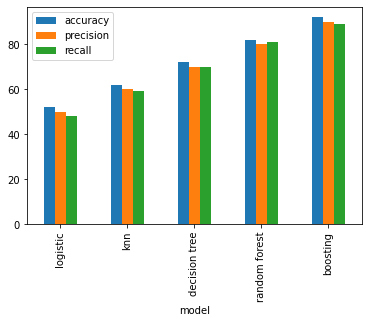

In [23]:
# Plot those results
results_df.plot(kind='bar')

## Model 1. Logistic Regression

In [25]:
# instantiate the model (note we increase max-iter here; default is 100)
logreg = LogisticRegression(max_iter=1000)

In [26]:
# fit your model on the training dataset
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [27]:
# predict on the testing dataset
y_preds=logreg.predict(X_test)
print('preds', list(y_preds[:10]))
print('truth', list(y_test[:10]))

preds [1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
truth [1, 1, 1, 0, 1, 0, 0, 0, 0, 0]


In [28]:
# calculate the accuracy of your predictions
print('accuracy',accuracy_score(y_preds, y_test))
print('precision',precision_score(y_preds, y_test))
print('recall',recall_score(y_preds, y_test))

accuracy 0.8490566037735849
precision 0.8378378378378378
recall 0.7560975609756098


In [29]:
# update our dictionary of results with those scores!
modelname='logistic'
results_df.loc[modelname,'accuracy']=round(accuracy_score(y_preds, y_test),2)
results_df.loc[modelname,'precision']=round(precision_score(y_preds, y_test),2)
results_df.loc[modelname,'recall']=round(recall_score(y_preds, y_test),2)
results_df

,accuracy,precision,recall
model,,,
logistic,0.85,0.84,0.76
knn,62.00,60.00,59.00
decision tree,72.00,70.00,70.00
random forest,82.00,80.00,81.00
boosting,92.00,90.00,89.00


## Model 2. KNN

In [30]:
# instantiate with K=10
knn = KNeighborsClassifier(n_neighbors=10)

In [31]:
# fit with data
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [32]:
# predict on the testing dataset
y_preds=knn.predict(X_test)
print('preds', list(y_preds[:10]))
print('truth', list(y_test[:10]))

preds [1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
truth [1, 1, 1, 0, 1, 0, 0, 0, 0, 0]


In [33]:
# calculate the accuracy of your predictions
print('accuracy',accuracy_score(y_preds, y_test))
print('precision',precision_score(y_preds, y_test))
print('recall',recall_score(y_preds, y_test))

accuracy 0.7830188679245284
precision 0.8648648648648649
recall 0.64


In [34]:
# update our dictionary of results with those scores!
modelname='knn'
results_df.loc[modelname,'accuracy']=round(accuracy_score(y_preds, y_test),2)
results_df.loc[modelname,'precision']=round(precision_score(y_preds, y_test),2)
results_df.loc[modelname,'recall']=round(recall_score(y_preds, y_test),2)
results_df

,accuracy,precision,recall
model,,,
logistic,0.85,0.84,0.76
knn,0.78,0.86,0.64
decision tree,72.00,70.00,70.00
random forest,82.00,80.00,81.00
boosting,92.00,90.00,89.00


## Decision Tree

In [35]:
# instantiate the model
tree = DecisionTreeClassifier()

In [36]:
# fit with data
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [37]:
# predict on the testing dataset
y_preds=tree.predict(X_test)
print('preds', list(y_preds[:10]))
print('truth', list(y_test[:10]))

preds [1, 0, 1, 0, 1, 0, 1, 0, 0, 1]
truth [1, 1, 1, 0, 1, 0, 0, 0, 0, 0]


In [38]:
# calculate the accuracy of your predictions
print('accuracy',accuracy_score(y_preds, y_test))
print('precision',precision_score(y_preds, y_test))
print('recall',recall_score(y_preds, y_test))

accuracy 0.7641509433962265
precision 0.7567567567567568
recall 0.6363636363636364


In [39]:
# update our dictionary of results with those scores!
modelname='decision tree'
results_df.loc[modelname,'accuracy']=round(accuracy_score(y_preds, y_test),2)
results_df.loc[modelname,'precision']=round(precision_score(y_preds, y_test),2)
results_df.loc[modelname,'recall']=round(recall_score(y_preds, y_test),2)
results_df

,accuracy,precision,recall
model,,,
logistic,0.85,0.84,0.76
knn,0.78,0.86,0.64
decision tree,0.76,0.76,0.64
random forest,82.00,80.00,81.00
boosting,92.00,90.00,89.00


## Random Forest

In [45]:
# instantiate the model
rand_forest = RandomForestClassifier(n_estimators = 100, random_state = 40)

In [46]:
# fit with data
rand_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=40)

In [47]:
# predict on the testing dataset
y_preds=rand_forest.predict(X_test)
print('preds', list(y_preds[:10]))
print('truth', list(y_test[:10]))

preds [1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
truth [1, 1, 1, 0, 1, 0, 0, 0, 0, 0]


In [48]:
# calculate the accuracy of your predictions
print('accuracy',accuracy_score(y_preds, y_test))
print('precision',precision_score(y_preds, y_test))
print('recall',recall_score(y_preds, y_test))

accuracy 0.8962264150943396
precision 0.8648648648648649
recall 0.8421052631578947


In [49]:
# update our dictionary of results with those scores!
modelname='random forest'
results_df.loc[modelname,'accuracy']=round(accuracy_score(y_preds, y_test),2)
results_df.loc[modelname,'precision']=round(precision_score(y_preds, y_test),2)
results_df.loc[modelname,'recall']=round(recall_score(y_preds, y_test),2)
results_df

,accuracy,precision,recall
model,,,
logistic,0.85,0.84,0.76
knn,0.78,0.86,0.64
decision tree,0.76,0.76,0.64
random forest,0.90,0.86,0.84
boosting,92.00,90.00,89.00


## Boosting

In [50]:
# instantiate the model
boosting = AdaBoostClassifier(n_estimators=100, random_state=40)

In [51]:
# fit with data
boosting.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=40)

In [52]:
# predict on the testing dataset
y_preds=boosting.predict(X_test)
print('preds', list(y_preds[:10]))
print('truth', list(y_test[:10]))

preds [1, 1, 0, 1, 1, 0, 0, 0, 1, 1]
truth [1, 1, 1, 0, 1, 0, 0, 0, 0, 0]


In [53]:
# calculate the accuracy of your predictions
print('accuracy',accuracy_score(y_preds, y_test))
print('precision',precision_score(y_preds, y_test))
print('recall',recall_score(y_preds, y_test))

accuracy 0.8207547169811321
precision 0.8378378378378378
recall 0.7045454545454546


In [54]:
# update our dictionary of results with those scores!
modelname='boosting'
results_df.loc[modelname,'accuracy']=round(accuracy_score(y_preds, y_test),2)
results_df.loc[modelname,'precision']=round(precision_score(y_preds, y_test),2)
results_df.loc[modelname,'recall']=round(recall_score(y_preds, y_test),2)
results_df

,accuracy,precision,recall
model,,,
logistic,0.85,0.84,0.76
knn,0.78,0.86,0.64
decision tree,0.76,0.76,0.64
random forest,0.90,0.86,0.84
boosting,0.82,0.84,0.70


## Compare your results

<AxesSubplot:xlabel='model'>

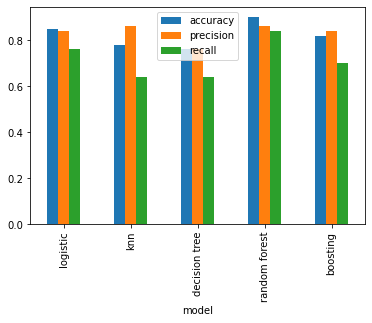

In [55]:
# Plot those results
results_df.plot(kind='bar')

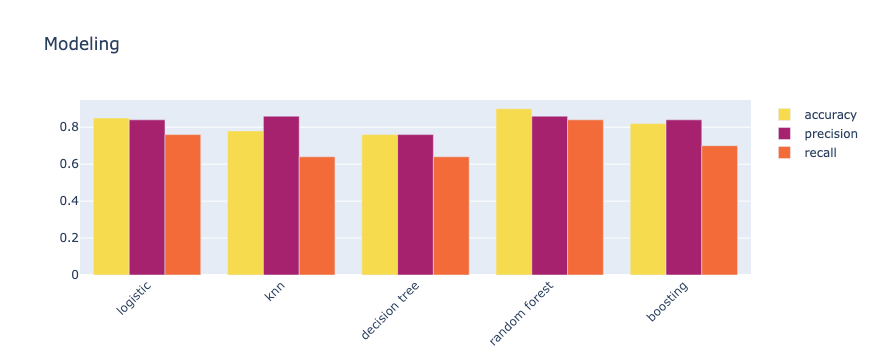

In [57]:
# quick reminder: how to build this with plotly so it looks nice.
colors=[ '#F7DB4F',  '#A7226E',   '#F26B38', '#2F9599', '#EC2049']
trace0=go.Bar(name=results_df.columns[0], x=results_df.index, y=results_df[results_df.columns[0]], marker_color=colors[0])
trace1=go.Bar(name=results_df.columns[1], x=results_df.index, y=results_df[results_df.columns[1]], marker_color=colors[1])
trace2=go.Bar(name=results_df.columns[2], x=results_df.index, y=results_df[results_df.columns[2]], marker_color=colors[2])

fig = go.Figure([trace0, trace1, trace2])
fig.update_layout(title='Modeling',  xaxis_tickangle=-45)
fig.show()
# https://digitalsynopsis.com/design/minimal-web-color-palettes-combination-hex-code/